In [ ]:
# look up mutations in chd

In [3]:
library(ggplot2)
library(viridis)
library(dplyr)

In [37]:
tab1 = read.delim('lof_het_mutations_cases.csv', sep = ',')
tab2 = read.delim('denovo_mutations_cases.csv', sep = ',')
# tab2 = read.delim('denovo_mutations_controls.csv', sep = ',')

tab1 <- tab1[,c('Cardiac.Category', 'EM', 'NDD', 'CHR', 'POS', 'Gene', 'ExonicFunc.refGene',
                'pLI.Score', 'HHE.Rank')]
tab2 <- tab2[,c('Cardiac.Category', 'EM', 'NDD', 'CHROM', 'POS', 'Gene', 'Variant_Class',
                'pLI.score', 'HHE.Rank')]

cols1 = c('Cardiac.Category', 'EM', 'NDD', 'chr', 'pos', 'Gene', 'Variant_Class', 'pLI', 'HHE_rank')
colnames(tab1) = cols1
colnames(tab2) = cols1
tab1$mutation = 'LoF_het'
tab2$mutation = 'denovo'

tab3 = rbind(tab1, tab2)
tab3$Cardiac.Category[(tab3$Cardiac.Category) %in% c('CTD (TGA)', ' CTD (TGA)')] = 'CTD_TGA'
tab3$Cardiac.Category[(tab3$Cardiac.Category) %in% c('other (AVC)', 'Other (AVC)')] = 'AVC'
tab3$Cardiac.Category[(tab3$Cardiac.Category) %in% c('OTHER', 'Other', 'other')] = 'other'
tab3[1,]

Cardiac.Category EM NDD chr pos      Gene   Variant_Class        pLI 
1 other            No Yes 12  58152532 MARCH9 frameshift_insertion 0.35
  HHE_rank mutation
1 36.2     LoF_het

In [30]:
# get cre for each point mutation
get_cre <- function(df, tab3){
    tab3$cre = 'no'
    
    for(ii in 1:dim(tab3)[1]){
        pos = tab3$pos[ii]
        ids = which(df$Chr==paste0('chr', tab3$chr[ii]))
        
        s1 = pos - df$Start[ids]
        print(df$End[ids])
        e1 = df$End[ids] - pos
        d1 = which(s1>0 & e1>0)

        if(length(d1)){
            tab3$cre[ii] = 'yes'
        }
        } 
    
    return(tab3$cre)
}

In [7]:
# all human heart cres
full = read.delim('human_heart_cre.tsv', sep = '\t', header = F)
dim(full)
colnames(full) = c('Chr', 'Start', 'End')
full[1,]

[1] 287415      3

Chr  Start  End   
1 chr1 794938 795248

In [66]:
df1 = read.delim('ESC_HGE.csv', sep = ',')
df2 = read.delim('MES_HGE.csv', sep = ',')
df3 = read.delim('CP_HGE.csv', sep = ',')
df4 = read.delim('celltype_specific_cre.csv', sep = ',')
dim(df1)
df1[1,]

[1] 13552    26

PeakID                  Chr   Start    End      Strand Peak.Score
1 Merged-chr10-94655063-1 chr10 94654839 94655288 +      1         
  Focus.Ratio.Region.Size             Annotation                        
1 human.H3K27ac.D00.hg19.crossmap.txt intron (NM_019053, intron 4 of 21)
  Detailed.Annotation                Distance.to.TSS ⋯
1 intron (NM_019053, intron 4 of 21) 46851           ⋯
  Gene.Alias                                 Gene.Description           
1 EXOC6A|SEC15|SEC15L|SEC15L1|SEC15L3|Sec15p exocyst complex component 6
  Gene.Type      ...160511.Cardio.combo.H3K27ac.D00..FPKM
1 protein-coding 2.18                                    
  ...160511.Cardio.combo.Input.D00..FPKM
1 0.49                                  
  ...GSE47949.mouse.H3K27ac.0.mESC.GSE47949..FPKM
1 0.92                                           
  ...GSE47949.mouse.Input.0.mESC.GSE47949..FPKM Human..log2.enrichment.
1 0.69                                          1.715359               
  Mouse..log2.enrichment. Diff    
1 0.3157759               1.399583

In [9]:
tab3$all_cre = get_cre(full, tab3)

In [12]:
tab3$esc_cre = get_cre(df1, tab3)
tab3$mes_cre = get_cre(df2, tab3)
tab3$cp_cre = get_cre(df3, tab3)

In [67]:
tab3$celltype_cre = get_cre(df4, tab3)

In [32]:
source('~/Atlas/primates/get_odds_ratio.R')

In [43]:
all_cre = sum(tab3$all_cre=='yes')
all_other = dim(full)[1] - all_cre
hge_cre = sum(tab3$cp_cre=='yes')
hge_other = dim(df3)[1] - hge_cre
mat1 = matrix(c(hge_cre, hge_other, all_cre-hge_cre, all_other-hge_other), nrow = 2)

rownames(mat1) = c('HGE CRE', 'shared CRE')
colnames(mat1) = c('CHD_in_CRE', 'CHD_out_CRE')
mat1
fisher.test(mat1)

CHD_in_CRE CHD_out_CRE
HGE CRE      81          971     
shared CRE 2239       284124


	Fisher's Exact Test for Count Data

data:  mat1
p-value < 2.2e-16
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  8.300816 13.340786
sample estimates:
odds ratio 
  10.58375 


In [63]:
temp = tab3 %>% group_by(Variant_Class, all_cre) %>% reframe(count = n())
temp <- temp[temp[,1]!='.' & temp[,1]!='',]
dff = get_odds_ratio(temp)
dff$odds[dff$odds<1] = NA
dff[1,]

group1     group2 count num_type count_classification p_cons_raw pf       
1 frameshift no     159   172      11992                0.598889   0.7069889
  odds p_cons    p_cons2  
1 NA   0.9932552 0.9964044

Warning message:
“Removed 11 rows containing missing values or values outside the scale range (`geom_point()`).”


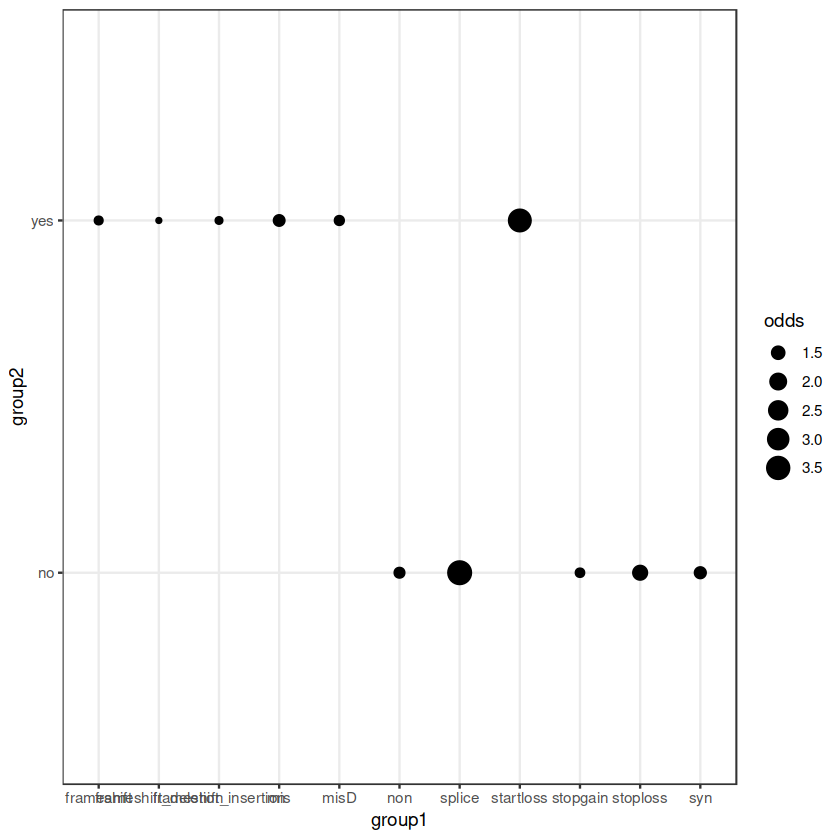

In [64]:
ggplot(dff, aes(x = group1, y = group2, size = odds)) + geom_point() + theme_bw()